<a href="https://colab.research.google.com/github/saadhashmi91/Revolut-FinCrimeChallenge/blob/master/FinCrimeChallenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Revolut - Financial Crime Machine Learning Challenge
## Introduction
This work focuses on using a machine learning algorithm of choice to predict fradulent monetary transactions using the data-sets provided.
> ## Data Sets Description
The already provided datasets include the following:
1. **Users.csv:**  Contains user registration records: ***CREATED_DATE***, ***COUNTRY***, ***BIRTH_DATE***.
2. **Transactions.csv:** Contains the users' transaction records:
>>1.   **ID:** Transaction ID
>>2.   **USER_ID**
>>3.   **CREATED_DATE:** Transaction Timestamp
>>4.   **TYPE:** Transaction Type. One of (***CARD_PAYMENT, TRANSFER, TOPUP, EXCHANGE, ATM, FEE***)
>>5.   **STATE:** State of Transaction. One of (***COMPLETED, DECLINED/FAILED, REVERTED***)
>>6.   **AMOUNT_GBP:** Transaction Amount in GBP
>>7.   **CURRENCY:** Actual Currency used for the Transaction.
3. **Fraudsters.csv**: List of Fraudsters ***USER_IDS*** for positive class labels.

> ## Feature Engineering
Features of each User were generated on a per transaction level. For this purpose the Apache Spark SQL Dataframe API was used to partition the transactions by **USER_ID** and **DATE**. Subsequently, rolling aggregates were generated on two partitions in parallel:
1. Partitioning By **USER_ID** Only, Ordered By **DATE_CREATED**:
>>1. **running_net_balance:** The running net balance of the user calculated by summing ***signed_balance*** (over each new transaction). The ***signed_balance*** is a derived column where the amounts of the transaction types (***CARD_PAYMENT, TRANSFER, ATM, FEE***) were considered as ***debits*** from the Revolut User Account and the transaction types (***TOPUP, EXCHANGE***) were considered as ***credits*** to the Revolut User Account.
>>2. **days_inactive:** The number of days the user had been inactive between two consecutive transactions.
>>3. **distinctCurrenciesAllTime:** The running total of distinct currencies used by the user over time.
>>4. **runningTopupsTotal:** The running total of ***TOPUP*** transactions conducted by the user over time.
>>5. **runningTotalFailedAllTime:** The running total of ***DECLINED/FAILED*** transactions conducted by the user over time.
>>6. **runningTotalRevertedAllTime:** The running total of ***REVERTED*** transactions conducted by the user over time.
2. Partitioning By **USER_ID** and **DATE**, Ordered By **DATE_CREATED**:
>>1. **total_transactions_per_day:** The total number of transactions conducted by the user in one day upto the current transaction.
>>2. **distinctTrnsPerDay:** The total number of distinct transaction types used by the user in one day upto the current transaction.
>>3. **distinctCurrenciesPerDay:** The total number of distinct currencies used by the user in one day upto the current transaction.
>>4. **topupRatio:** The fraction of ***TOPUP*** transactions conducted by the user upto the current transaction.
>>5. **runningTotalFailedPerDay:** The total number of ***DECLINED/FAILED*** transactions per day upto the current transaction.
>>6. **runningTotalRevertedPerDay:** The total number of ***REVERTED*** transactions per day upto the current transaction.
>>7. **minTransactionAmountToday:** The minimum transaction amount used by the user per day upto the current transaction.
>>8. **maxTransactionAmountToday:** The maximum transaction amount used by the user per day upto the current transaction.
>>9. **avgTransactionAmountToday:** The average of all transaction amounts by the user per day upto the current transaction.

>Apart from the above the transaction-level textual columns (***TYPE***, ***STATE*** and ***CURRENCY***) have been converted to categorical numerical values while model training. The sample of the users features is shown below:















In [0]:
import pandas as pd
data_path = './data/'
users_features_path = data_path  + 'users_features3.csv'
users_features_df = pd.read_csv(users_features_path)
users_features_df.head(10)

,ID,USER_ID,CREATED_DATE,AMOUNT_GBP,TYPE,CURRENCY,STATE,running_net_balance,total_transactions_per_day,days_inactive,...,distinctCurrenciesAllTime,topupRatio,runningTopupsTotal,runningTotalFailedPerDay,runningTotalFailedAllTime,runningTotalRevertedPerDay,runningTotalRevertedAllTime,minTransactionAmountToday,maxTransactionAmountToday,avgTransactionAmountToday
0,9499c9c9-c9a9-410f-820d-c6e92fed27fb,00001f33-1d47-47a3-8955-e719172e788b,2019-04-11 20:53:54.7,0.01,TOPUP,EUR,REVERTED,0.01,1,0,...,1,1.000000,1,0,0,1,1,0.01,0.01,0.010000
1,b310db00-490f-4185-b247-c59f5694dd67,00001f33-1d47-47a3-8955-e719172e788b,2019-04-11 20:54:02.156,8.92,TOPUP,EUR,COMPLETED,8.93,2,0,...,1,1.000000,2,0,0,1,1,0.01,8.92,4.465000
2,e6021128-f4c1-4164-b3de-697e66ad613c,00001f33-1d47-47a3-8955-e719172e788b,2019-04-11 20:55:20.996,5.34,FEE,EUR,COMPLETED,3.59,3,0,...,1,0.666667,2,0,0,1,1,0.01,8.92,4.756667
3,a9aa681d-451e-44c5-8df0-687661ac583d,00001f33-1d47-47a3-8955-e719172e788b,2019-04-19 21:05:53.192,115.84,TOPUP,EUR,COMPLETED,119.43,1,8,...,1,1.000000,3,0,0,0,1,115.84,115.84,115.840000
4,1be7d138-fbaf-4216-8dc8-5056ec5f972c,00001f33-1d47-47a3-8955-e719172e788b,2019-04-21 10:14:53.814,44.44,CARD_PAYMENT,EUR,COMPLETED,74.99,1,2,...,1,0.000000,3,0,0,0,1,44.44,44.44,44.440000
5,46285eca-e1b1-43a2-b8b0-c173b48f5a95,00001f33-1d47-47a3-8955-e719172e788b,2019-04-21 11:04:53.081,46.89,CARD_PAYMENT,EUR,COMPLETED,28.10,2,0,...,1,0.000000,3,0,0,0,1,44.44,46.89,45.665000
6,ce8c9947-783e-4153-aa34-d7507214183a,00001f33-1d47-47a3-8955-e719172e788b,2019-04-21 11:26:25.494,44.44,TOPUP,EUR,COMPLETED,72.54,3,0,...,1,0.333333,4,0,0,0,1,44.44,46.89,45.256667
7,b0e8dfc6-75eb-4c89-9653-b5ea1ab13129,00005048-a584-4b94-a0fc-481c7bc916f1,2019-04-08 08:59:06.961,0.01,TOPUP,GBP,REVERTED,0.01,1,0,...,1,1.000000,1,0,0,1,1,0.01,0.01,0.010000
8,51ca77fb-e857-4439-ab1a-d8aa0f7248a1,00005048-a584-4b94-a0fc-481c7bc916f1,2019-04-08 08:59:18.715,10.00,TOPUP,GBP,COMPLETED,10.01,2,0,...,1,1.000000,2,0,0,1,1,0.01,10.00,5.005000
9,b9f91427-8a2a-4eef-9754-4fa48fb6d706,00005048-a584-4b94-a0fc-481c7bc916f1,2019-04-08 09:23:46.26,0.01,CARD_PAYMENT,USD,COMPLETED,10.00,3,0,...,2,0.666667,2,0,0,1,1,0.01,10.00,3.340000


In [0]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")


## Class Imbalance Handling
We can notice that the original dataset is highly imbalanced! Most of the transactions are non-fraud. To overcome over-fitting of the various predictive models created, we will utilize under-sampling technqiue. More specifically we will create a subsample dataframe with a 50/50 ratio of fraud and non-fraud transactions. Meaning our sub-sample will have the same amount of fraud and non fraud transactions.

In [0]:

users_path = data_path + 'users.csv'

fraudsters_path = data_path + 'fraudsters.csv'

transactions_path = data_path  + 'transactions.csv'

users_features_path = data_path  + 'users_features3.csv'

transactions = pd.read_csv(transactions_path)

users = pd.read_csv(users_path)
now = pd.Timestamp('now')
users['dob'] = pd.to_datetime(users['BIRTH_DATE'], infer_datetime_format=True)
users['dob'] = users['dob'].where(users['dob'] < now, users['dob'] -  np.timedelta64(100, 'Y'))    
users['AGE'] =  (now - users['dob']).astype('<m8[Y]')
users['USER_ID'] = users['ID']
users1 = users.drop('dob', axis=1).drop('BIRTH_DATE',axis=1).drop('CREATED_DATE',axis=1).drop('ID',axis=1)

fraudsters = pd.read_csv(fraudsters_path)

users_features = pd.read_csv(users_features_path)

#transactions['DATE'] = pd.to_datetime(transactions['CREATED_DATE'], format='%Y-%m-%d %H:%M:%S.%f', errors='ignore').dt.date

key_diff = set(transactions['USER_ID']).difference(fraudsters['USER_ID'])

where_diff = transactions['USER_ID'].isin(key_diff)

print(transactions.size)
print(transactions[where_diff].size)
print(len(transactions[transactions['USER_ID'].isin(fraudsters['USER_ID'])]))

#transactions_df = spark.createDataFrame(transactions)
#transactions_df.cache()

#windowSpec = Window.partitionBy(transactions_df['USER_ID']).orderBy(transactions_df['DATE'].asc())

#running_net_balance_per_user = func.sum(transactions_df['AMOUNT_GBP']).over(windowSpec)

#transactions_df.filter(transactions_df['TYPE']=='TOPUP').select(transactions_df['USER_ID'],transactions_df['DATE'],running_net_balance_per_user).show()

#transactions['day_diff'] = transactions.sort_values(['USER_ID', 'CREATED_DATE'], ascending=True).groupby('USER_ID')['DATE'].diff() / np.timedelta64(1, 'D')
#running_net_balance_per_user= transactions[where_diff].sort_values(['USER_ID', 'DATE'], ascending=True).groupby(['USER_ID','DATE','TYPE'], as_index = False).agg({'AMOUNT_GBP': [np.min,np.max,np.mean,np.sum,np.size],'TYPE': pd.Series.nunique,'DATE': lambda x: x.diff() / np.timedelta64(1, 'D')}).groupby(level=[0]).cumsum()

#running_net_balance_per_user['days_diff'] = running_net_balance_per_user['DATE'].diff() / np.timedelta64(1, 'D')
#running_net_balance_per_fraudster= transactions[transactions['USER_ID'].isin(fraudsters['USER_ID'].values)].groupby(['USER_ID','DATE']).agg({'AMOUNT_GBP': [np.sum]}).sort_values(['USER_ID', 'DATE'], ascending=True).groupby(level=[0]).cumsum()
#running_net_balance_per_user.head(10)
#number_days_consecutive_topups = transa

#running_net_balance_per_fraudster.hist(column=['AMOUNT_GBP'],bins=70)

#running_net_balance_per_user.
#fraudsters.sort_values('USER_ID',ascending=True).head(5)
#transactions[where_diff].sort_values('USER_ID',ascending=True).head(5)

users_features['datetime'] = pd.to_datetime(users_features['CREATED_DATE'], infer_datetime_format=True).astype(int) / 10**9
users_features =  pd.merge(users_features, users1, on='USER_ID')
users_features['COUNTRY'] = users_features['COUNTRY'].astype('category')

#Enumerate Dict of country codes

country_codes = dict(enumerate( users_features['COUNTRY'].cat.categories))

users_features['STATE'] = users_features['STATE'].astype('category')

users_features=users_features.drop('CURRENCY',axis=1).drop('TYPE',axis=1)
cat_columns = users_features.select_dtypes(['category']).columns
users_features[cat_columns] = users_features[cat_columns].apply(lambda x: x.cat.codes)
users_features.loc[users_features['USER_ID'].isin(fraudsters['USER_ID']),'Class']=1
users_features.loc[users_features['USER_ID'].isin(key_diff),'Class']=0

print('No Frauds', round(users_features['Class'].value_counts()[0]/len(users_features) * 100,2), '% of the dataset')
print('Frauds', round(users_features['Class'].value_counts()[1]/len(users_features) * 100,2), '% of the dataset')



7478527
7420973
8222
No Frauds 99.23 % of the dataset
Frauds 0.77 % of the dataset


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

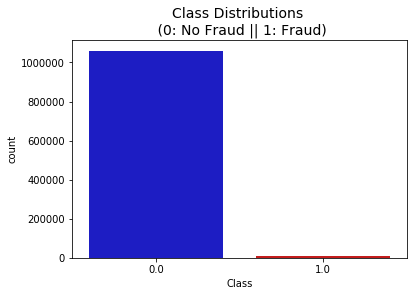

In [0]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('Class', data=users_features, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

###**Distributions**:
 By seeing the distributions we can have an idea how skewed are these features, we can also see further distributions of the other features. The distributions of ***Transaction Amounts*** and  ***Transaction Times*** have been shown below.

(1554250177.571, 1558140658.493)

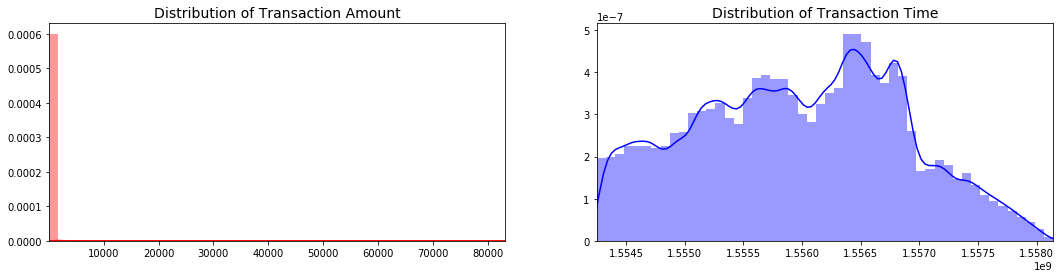

In [0]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = users_features['AMOUNT_GBP'].values
time_val = users_features['datetime'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

##Summary:
1. There are 8222 cases of fraud in our dataset so we can randomly get 8222 cases of non-fraud to create our new sub dataframe. We concat the 8222 cases of fraud and non fraud, creating a new sub-sample.
2. Rather than taking all the fraudsters' transactions for the training, we select 20% of the fraudsters for test-set in production and 80% of the fraudsters for trainining/validation set. With those percentages we concat 40% more non-fradulent users' transactions for each of the previous fraudster fractions to compile the training/validation set and production test set.

In [0]:
#Randomly shuffle list of fraudsters

shuffle_indices = np.arange(fraudsters['USER_ID'].shape[0])
np.random.shuffle(shuffle_indices)
fraudsters_shuffled = fraudsters['USER_ID'].values[shuffle_indices]

#Select 20% of the fraudsters for test-set in production and 80% of the fraudsters for trainining/validation set
dev_sample_index = -1 * int(0.20 * float(len(fraudsters_shuffled)))  # test set 40 percent

fraudsters_train_valid_test, fraudsters_test_prod = fraudsters_shuffled[:dev_sample_index], fraudsters_shuffled[dev_sample_index:]
print('Number of fraudsters in training set: ',len(fraudsters_train_valid_test))
print('Number of fraudsters in production test set: ',len(fraudsters_test_prod))
print('Ratio of frausters test/train: ',len(fraudsters_test_prod)/len(fraudsters_train_valid_test) )


# Extract 40 % more non-fraudsters than number of fraudsters_test_prod for production test
num_fraudsters = len(fraudsters_test_prod)
num_non_fraudsters_for_test_prod = int(round(num_fraudsters * 1.4,0))
#print(num_non_fraudsters_for_test_prod)
non_fraudsters_ids = set(transactions['USER_ID']).difference(fraudsters['USER_ID'])


#Shuffle non_fraudsters_ids
non_fraudsters_ids = list(non_fraudsters_ids)
np.random.shuffle(non_fraudsters_ids)


#Select num_non_fraudsters_for_test_prod from shuffled list above.
non_fraudsters_ids_shuffled_limited  = non_fraudsters_ids[:num_non_fraudsters_for_test_prod]
non_fraudsters_prod_test = users_features['USER_ID'].isin(non_fraudsters_ids_shuffled_limited)
non_fraudsters_features_df_prod_test = users_features[non_fraudsters_prod_test]
print('Number of transactions of non_fraudsters in production:',len(non_fraudsters_features_df_prod_test))

#Select rest of non_fraudsters for training and validation and test while model creation.
non_fraudsters_ids_shuffled_training  = non_fraudsters_ids[num_non_fraudsters_for_test_prod:]
non_fraudsters_train_validate = users_features['USER_ID'].isin(non_fraudsters_ids_shuffled_training)
non_fraudsters_features_df_train_validate = users_features[non_fraudsters_train_validate]


#Extract users_features from fraudsters_test_prod
fraudsters_prod_test = users_features['USER_ID'].isin(fraudsters_test_prod) 
fraudsters_features_df_prod_test = users_features[fraudsters_prod_test]
print('Number of transactions of fraudsters in production:',len(fraudsters_features_df_prod_test))


#Extract users_features from fraudsters_train_valid_test
fraudsters_train_validate = users_features['USER_ID'].isin(fraudsters_train_valid_test) 
fraudsters_features_df_train_valid_test = users_features[fraudsters_train_validate]



# Mix the two production DFs for test in production
frames = [non_fraudsters_features_df_prod_test,fraudsters_features_df_prod_test]
concatenated_prod  = pd.concat(frames)

# Mix the two train/validate DFs for train,validate and test while model creation
frames = [non_fraudsters_features_df_train_validate,fraudsters_features_df_train_valid_test]
concatenated_train = pd.concat(frames)

# Sort by DATE_CREATED
final_features_df_train_validate_test = concatenated_train.sort_values(by = ['CREATED_DATE'])
final_features_df_prod_test = concatenated_prod.sort_values(by = ['CREATED_DATE'])


print('No Frauds for prod_test', round(final_features_df_prod_test['Class'].value_counts()[0]/len(final_features_df_prod_test) * 100,2), '% of the dataset')
print('Frauds for prod_test', round(final_features_df_prod_test['Class'].value_counts()[1]/len(final_features_df_prod_test) * 100,2), '% of the dataset')


#Extract Transactions for production test
transactions_prod_test = transactions[transactions['USER_ID'].isin(final_features_df_prod_test['USER_ID'])]


# Drop text columns from users_features for training the model
#transactions_prod_test.head(10)
#print(len(transactions_prod_test))

final_features_df_train_validate_test=final_features_df_train_validate_test.drop('CREATED_DATE',axis=1).drop('USER_ID', axis = 1).drop('ID', axis = 1)

Number of fraudsters in training set:  606
Number of fraudsters in production test set:  151
Ratio of frausters test/train:  0.24917491749174916
Number of transactions of non_fraudsters in production: 1097
Number of transactions of fraudsters in production: 1317
No Frauds for prod_test 45.44 % of the dataset
Frauds for prod_test 54.56 % of the dataset



##Random Under-Sampling:

We will implement "Random Under Sampling" on the *final_features_df_train_validate_test* dataframe, which basically consists of removing data in order to have a more balanced dataset and thus avoiding our models to overfitting.
> **Steps**:
1. The first thing we have to do is determine how imbalanced is our class (use "value_counts()" on the class column to determine the amount for each label)
2. Once we determine how many instances are considered fraud transactions (Fraud = "1") , we should bring the non-fraud transactions to the same amount as fraud transactions (assuming we want a 50/50 ratio), this will be equivalent to 606 cases of fraud and 606 cases of non-fraud transactions.
3. After implementing this technique, we have a sub-sample of our dataframe with a 50/50 ratio with regards to our classes. Then the next step we will implement is to shuffle the data to see if our models can maintain a certain accuracy everytime we run this script.

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No Frauds', round(final_features_df_train_validate_test['Class'].value_counts()[0]/len(final_features_df_train_validate_test) * 100,2), '% of the dataset')
print('Frauds', round(final_features_df_train_validate_test['Class'].value_counts()[1]/len(final_features_df_train_validate_test) * 100,2), '% of the dataset')


X = final_features_df_train_validate_test.drop('Class', axis=1)
y = final_features_df_train_validate_test['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

No Frauds 99.35 % of the dataset
Frauds 0.65 % of the dataset
Train: [ 213075  213076  213077 ... 1065944 1065945 1065946] Test: [     0      1      2 ... 226575 226583 226684]
Train: [      0       1       2 ... 1065944 1065945 1065946] Test: [213075 213076 213077 ... 426377 426378 426835]
Train: [      0       1       2 ... 1065944 1065945 1065946] Test: [426379 426380 426381 ... 639706 639707 639708]
Train: [      0       1       2 ... 1065944 1065945 1065946] Test: [615509 615578 615598 ... 855027 855274 856018]
Train: [     0      1      2 ... 855027 855274 856018] Test: [ 852752  852753  852754 ... 1065944 1065945 1065946]


In [0]:
# Check the Distribution of the labels


# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.9935222 0.0064778]
[0.99352218 0.00647782]


In [0]:
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples

final_features_df_train_validate_test = final_features_df_train_validate_test.sample(frac=1)

# amount of fraud classes number rows.
fraud_df = final_features_df_train_validate_test.loc[final_features_df_train_validate_test['Class'] == 1]
num_fraud_cases = final_features_df_train_validate_test['Class'].value_counts()[1]
non_fraud_df = final_features_df_train_validate_test.loc[final_features_df_train_validate_test['Class'] == 0][:num_fraud_cases]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,AMOUNT_GBP,STATE,running_net_balance,total_transactions_per_day,days_inactive,distinctTrnsPerDay,distinctCurrenciesPerDay,distinctCurrenciesAllTime,topupRatio,runningTopupsTotal,...,runningTotalFailedAllTime,runningTotalRevertedPerDay,runningTotalRevertedAllTime,minTransactionAmountToday,maxTransactionAmountToday,avgTransactionAmountToday,datetime,COUNTRY,AGE,Class
208761,50.00,0,60.06,14,0,3,1,1,0.714286,10,...,5,1,1,0.01,6.99,20.002857,1.555957e+09,18,20.0,1.0
917478,0.01,0,3.52,8,0,2,2,2,0.250000,2,...,2,1,1,0.01,62.17,15.105000,1.554643e+09,14,20.0,0.0
646118,50.00,0,60.01,1,13,1,1,1,1.000000,3,...,0,0,1,50.00,50.00,50.000000,1.555501e+09,18,59.0,0.0
505502,0.01,2,0.01,1,0,1,1,1,1.000000,1,...,1,0,0,0.01,0.01,0.010000,1.554340e+09,18,20.0,1.0
544471,17.61,0,2067.27,1,1,1,1,2,0.000000,12,...,6,0,1,17.61,17.61,17.610000,1.556005e+09,18,62.0,0.0


Distribution of the Classes in the subsample dataset
0.0    0.5
1.0    0.5
Name: Class, dtype: float64


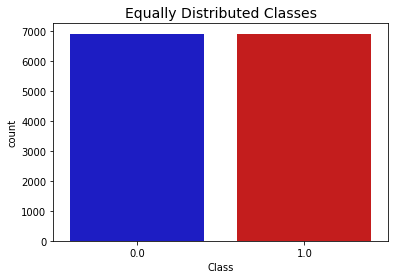

In [0]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts()/len(new_df))



sns.countplot('Class', data=new_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

## Features Correlation Matrices

Correlation matrices are the essence of understanding our data. We want to know if there are features that influence heavily in whether a specific transaction is a fraud. However, it is important that we use the correct dataframe (subsample) in order for us to see which features have a high positive or negative correlation with regards to fraud transactions.

 **Summary:**

 1. ***days_inactive, distinctCurrenciesPerDay, distinctCurrenciesAllTime, COUNTRY, AGE*** are ***negatively*** correlated.The lower these values are, the more likely the end result will be a fraud transaction. 
 2. ***runningTopupsTotal, total_transactions_per_day*** are ***positively*** correlated. The higher these values are, the more likely the end result will be a fraud transaction.

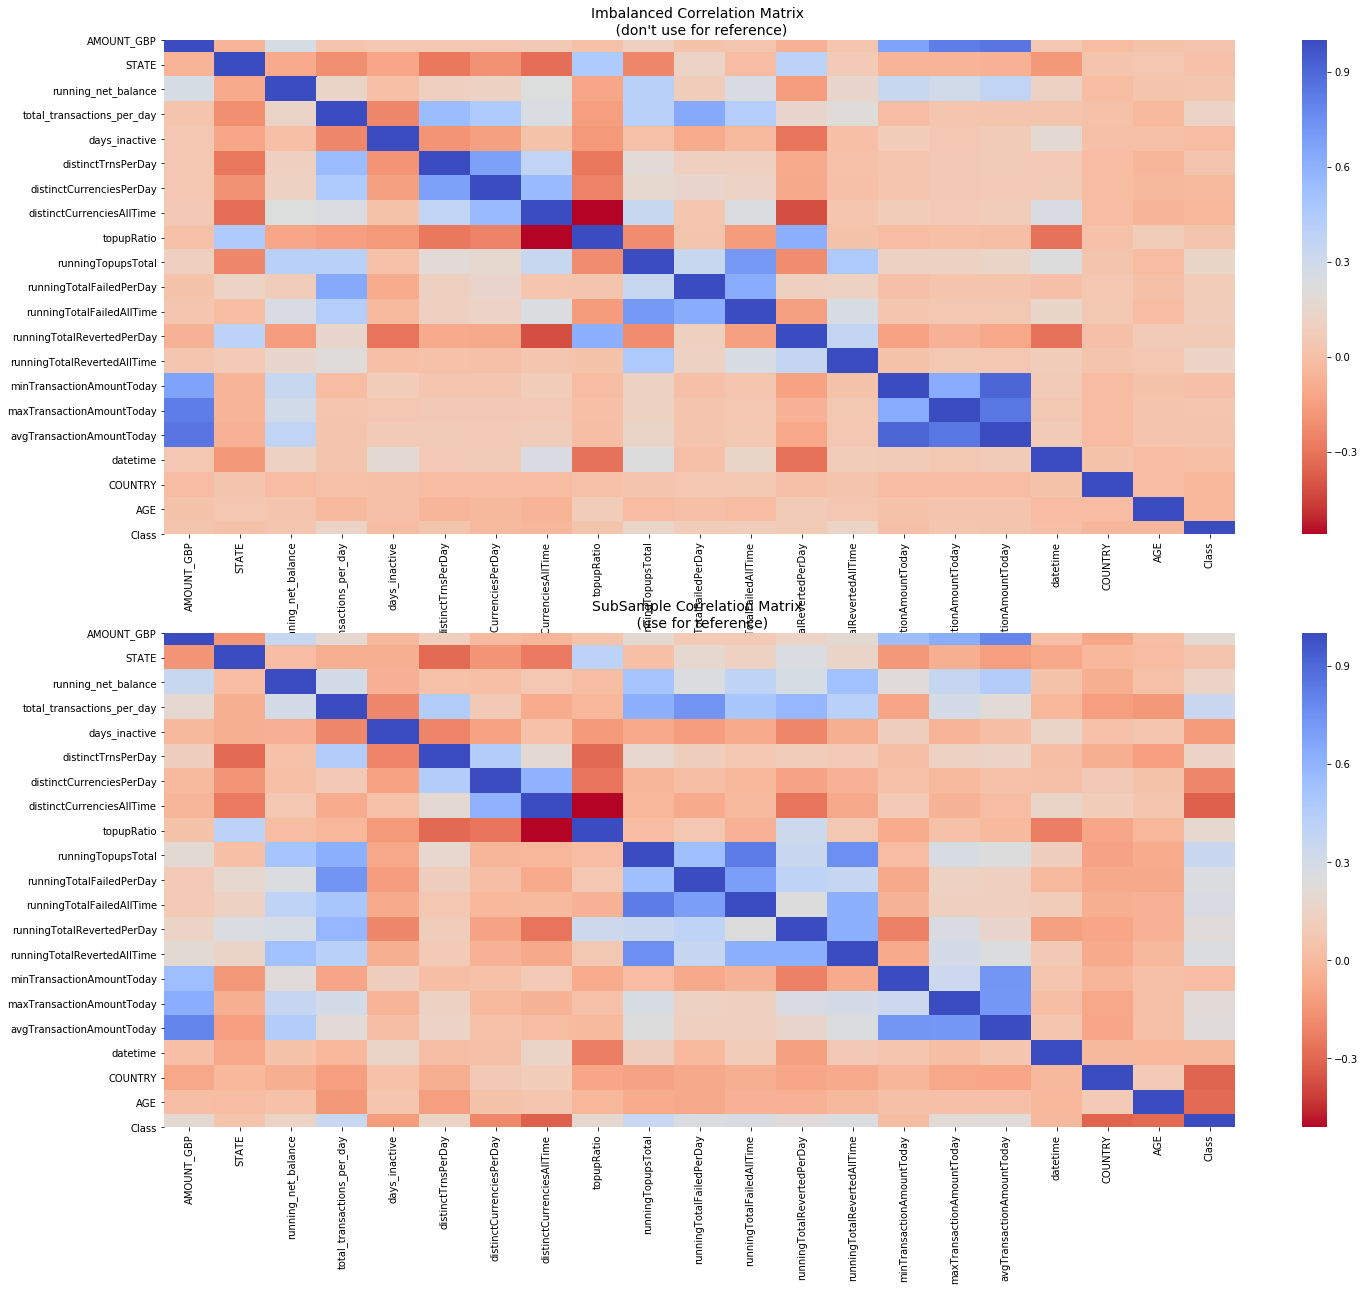

In [0]:
# Make sure we use the subsample in our correlation

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = users_features.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)


sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

##BoxPlots
We will use boxplots to have a better understanding of the distribution of these features in fradulent and non fradulent transactions. 

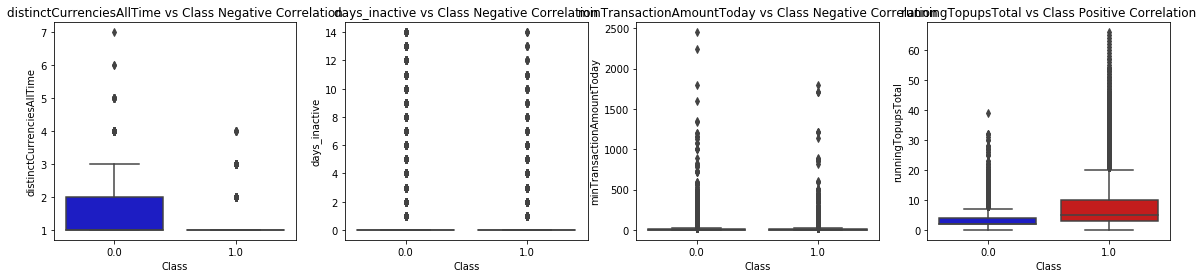

In [0]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="distinctCurrenciesAllTime", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('distinctCurrenciesAllTime vs Class Negative Correlation')

sns.boxplot(x="Class", y="days_inactive", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('days_inactive vs Class Negative Correlation')


sns.boxplot(x="Class", y="minTransactionAmountToday", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('minTransactionAmountToday vs Class Negative Correlation')


sns.boxplot(x="Class", y="runningTopupsTotal", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('runningTopupsTotal vs Class Positive Correlation')

plt.show()

In [0]:
# Undersampling before cross validating
X = new_df.drop('Class', axis=1)
y = new_df['Class']

In [0]:
# We should split our training and test sets
from sklearn.model_selection import train_test_split

# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [0]:
# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

## Machine Learning Classifiers Used

In this attempt, four Machine Learning Algorithms have been used to separately create four predictive models and compare their performance:
1. **Logistic Regression**
2. **K-Nearest Neighbours**
3. **Binary Support Vector Classifier**
4. **Decision Tree Classifier**

The following re-ranks the classifiers in order of their models training and validation accuracy:

1. **Decision Tree Classifier (88% accuracy score)**
2. **K-Nearest Neighbours (69% accuracy score)**
3. **Logistic Regression (51% accuracy score)**
4. **Support Vector Classifier (51% accuracy score)**

In [0]:
# Let's implement simple classifiers

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [0]:
from sklearn.model_selection import cross_val_score

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")
   

Classifiers:  LogisticRegression Has a training score of 54.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 70.0 % accuracy score
Classifiers:  SVC Has a training score of 50.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 87.0 % accuracy score


In [0]:
# We will undersample during cross validating
undersample_X = final_features_df_train_validate_test.drop('Class', axis=1)
undersample_y = final_features_df_train_validate_test['Class']

for train_index, test_index in sss.split(undersample_X, undersample_y):
    print("Train:", train_index, "Test:", test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]
    
undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values 

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

# Implementing NearMiss Technique 
# Distribution of NearMiss (Just to see how it distributes the labels we won't use these variables)
#X_nearmiss, y_nearmiss = NearMiss().fit_sample(undersample_X.values, undersample_y.values)
#print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))
# Cross Validating the right way

for train, test in sss.split(undersample_Xtrain, undersample_ytrain):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), classifiers.get('LogisiticRegression'))
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])
    
    undersample_accuracy.append(undersample_pipeline.score(original_Xtrain[test], original_ytrain[test]))
    undersample_precision.append(precision_score(original_ytrain[test], undersample_prediction))
    undersample_recall.append(recall_score(original_ytrain[test], undersample_prediction))
    undersample_f1.append(f1_score(original_ytrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(original_ytrain[test], undersample_prediction))

Train: [ 212184  212204  212256 ... 1065944 1065945 1065946] Test: [     0      1      2 ... 213201 213202 213203]
Train: [      0       1       2 ... 1065944 1065945 1065946] Test: [212184 212204 212256 ... 426394 426395 426396]
Train: [      0       1       2 ... 1065944 1065945 1065946] Test: [422592 422870 423174 ... 639566 639567 639673]
Train: [      0       1       2 ... 1065944 1065945 1065946] Test: [639568 639569 639570 ... 852764 852765 852766]
Train: [     0      1      2 ... 852764 852765 852766] Test: [ 850625  850778  850904 ... 1065944 1065945 1065946]


In [0]:
# Helper Function to Plot Each Classifier's Learning Curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator,title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
  
    plt.figure(figsize=(12,8))
    #if ylim is not None:
    #    plt.ylim(*ylim)
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    plt.title(title, fontsize=14)
    plt.xlabel('Training size (m)')
    plt.ylabel('Score')
    plt.grid(True)
    plt.legend(loc="best")
    return plt

## Logistic Regression Learning Curve

<module 'matplotlib.pyplot' from '/home/saad/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

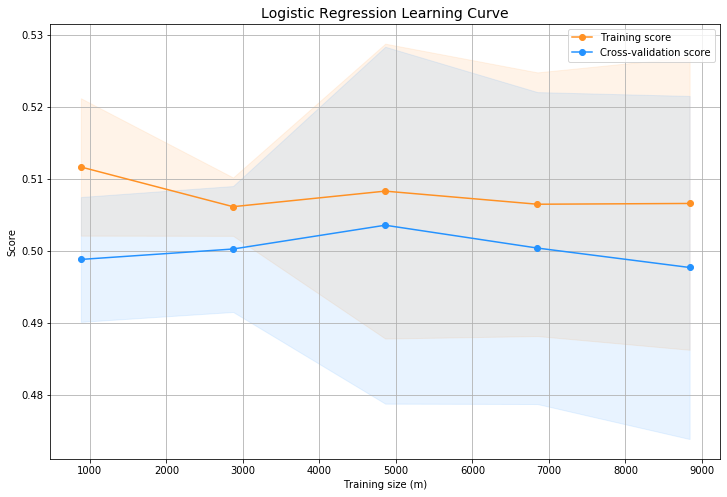

In [0]:
 cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
 plot_learning_curve(classifiers.get('LogisiticRegression'),"Logistic Regression Learning Curve", X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)


## KNearest Learning Curve

<module 'matplotlib.pyplot' from '/home/saad/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

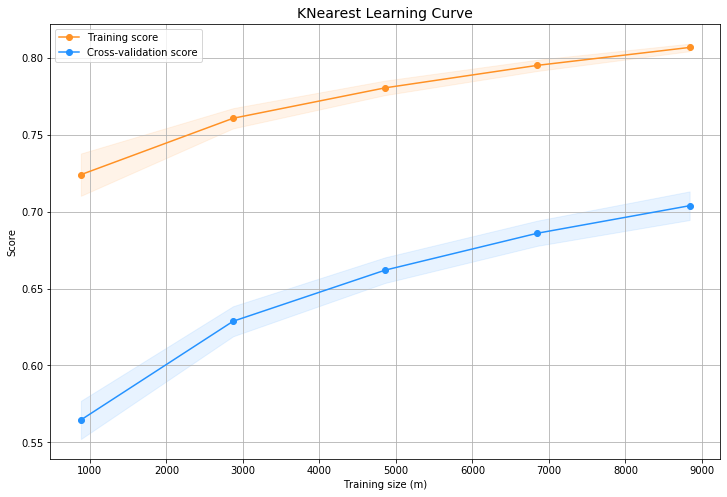

In [0]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(classifiers.get('KNearest'),"KNearest Learning Curve", X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)

In [0]:
plot_svc_curve = False

if plot_svc_curve:
  cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
  plot_learning_curve(classifiers.get('Support Vector Classifier'),"Support Vector Classifier Learning Curve", X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)

## DecisionTree Learning Curve

<module 'matplotlib.pyplot' from '/home/saad/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

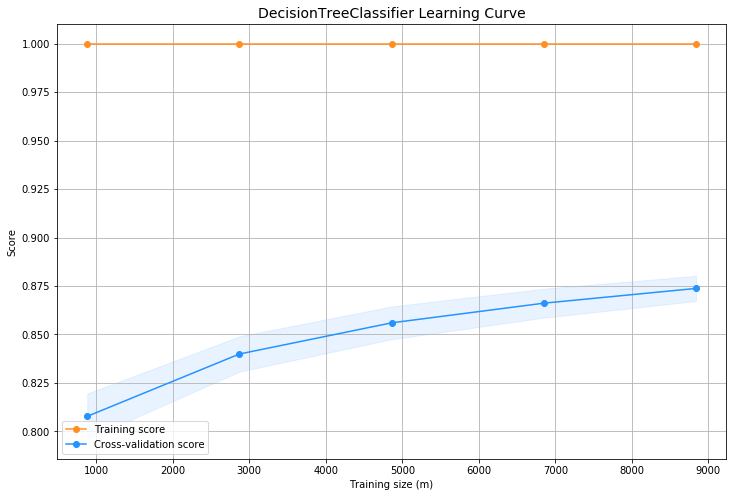

In [0]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(classifiers.get('DecisionTreeClassifier'),"DecisionTreeClassifier Learning Curve", X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)

## Cross-Validation Prediction Scores

In [0]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
# Create a DataFrame with all the scores and the classifiers names.

log_reg_pred = cross_val_predict(classifiers.get('LogisiticRegression'), X_train, y_train, cv=5,
                             method="decision_function")

knears_pred = cross_val_predict(classifiers.get('KNearest'), X_train, y_train, cv=5)

svc_pred = cross_val_predict(classifiers.get('Support Vector Classifier'), X_train, y_train, cv=5,
                             method="decision_function")

tree_pred = cross_val_predict(classifiers.get('DecisionTreeClassifier'), X_train, y_train, cv=5)

In [0]:
from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))

Logistic Regression:  0.5814785443293362
KNears Neighbors:  0.7045785378504634
Support Vector Classifier:  0.4981664658718572
Decision Tree Classifier:  0.8734666298886036


## ROC Curve Top 4 Classifiers

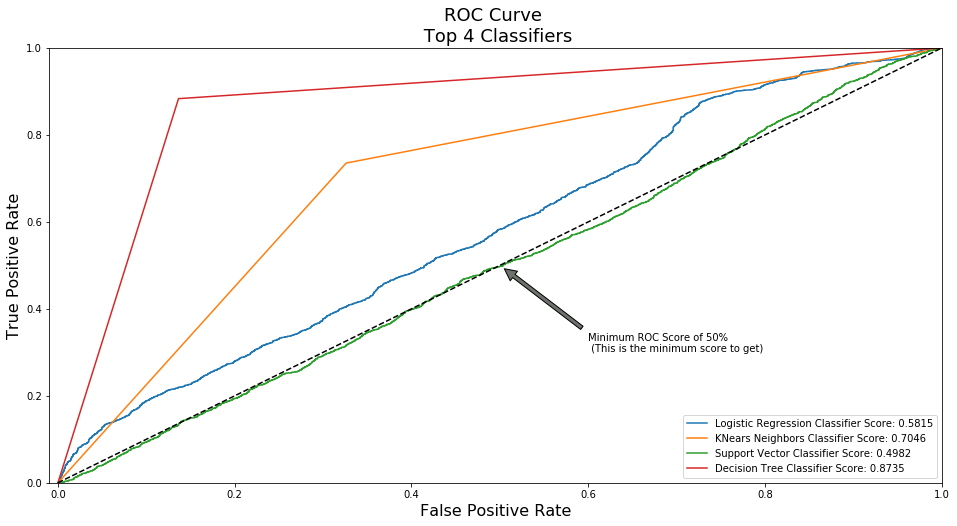

In [0]:
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)


def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.show()

## Decision Tree ROC Curve

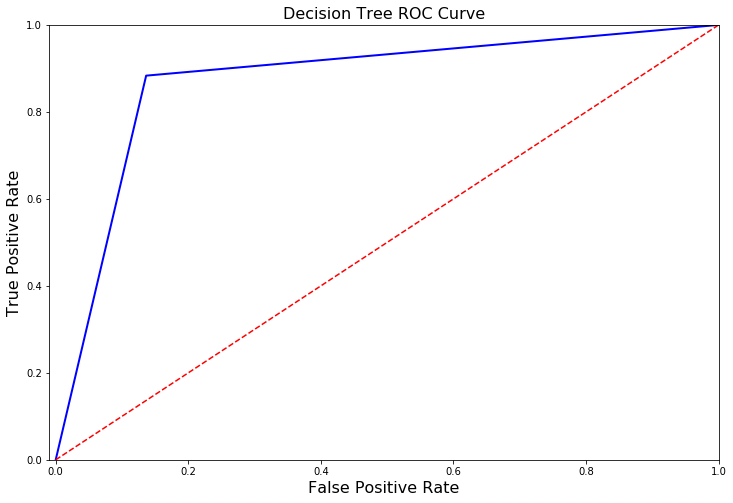

In [0]:
def tree_roc_curve(tree_fpr, tree_tpr):
    plt.figure(figsize=(12,8))
    plt.title('Decision Tree ROC Curve', fontsize=16)
    plt.plot(tree_fpr, tree_tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])
    
    
tree_roc_curve(tree_fpr, tree_tpr)
plt.show()


In [0]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_train, tree_pred)

In [0]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
y_pred = classifiers.get('DecisionTreeClassifier').predict(X_train)

# Overfitting Case
print('---' * 45)
print('Overfitting: \n')
print('Recall Score: {:.2f}'.format(recall_score(y_train, y_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_train, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_train, y_pred)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_train, y_pred)))
print('---' * 45)

# How it should look like
print('---' * 45)
print('How it should be:\n')
print("Accuracy Score: {:.2f}".format(np.mean(undersample_accuracy)))
print("Precision Score: {:.2f}".format(np.mean(undersample_precision)))
print("Recall Score: {:.2f}".format(np.mean(undersample_recall)))
print("F1 Score: {:.2f}".format(np.mean(undersample_f1)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------
Overfitting: 

Recall Score: 1.00
Precision Score: 1.00
F1 Score: 1.00
Accuracy Score: 1.00
---------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------
How it should be:

Accuracy Score: 0.20
Precision Score: 0.01
Recall Score: 0.80
F1 Score: 0.01
---------------------------------------------------------------------------------------------------------------------------------------


## Confusion Matrices

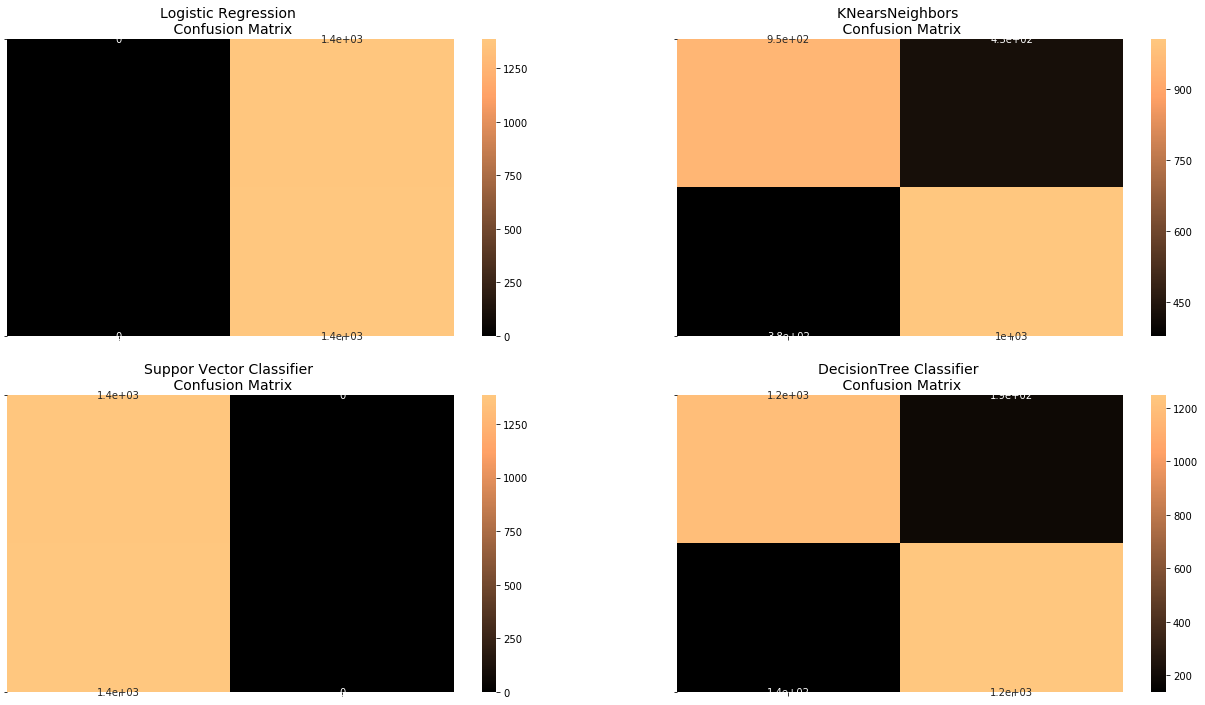

In [0]:
from sklearn.metrics import confusion_matrix

# Logistic Regression fitted with UnderSampling
log_reg = classifiers.get('LogisiticRegression')
y_pred_log_reg = log_reg.predict(X_test)

# Other models fitted with UnderSampling
knears_neighbours = classifiers.get('KNearest')
y_pred_knear = knears_neighbours.predict(X_test)

svc=classifiers.get('Support Vector Classifier')
y_pred_svc = svc.predict(X_test)

tree_clf=classifiers.get('DecisionTreeClassifier')
y_pred_tree = tree_clf.predict(X_test)


log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)
kneighbors_cf = confusion_matrix(y_test, y_pred_knear)
svc_cf = confusion_matrix(y_test, y_pred_svc)
tree_cf = confusion_matrix(y_test, y_pred_tree)

fig, ax = plt.subplots(2, 2,figsize=(22,12))


sns.heatmap(log_reg_cf, ax=ax[0][0], annot=True, cmap=plt.cm.copper)
ax[0, 0].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(kneighbors_cf, ax=ax[0][1], annot=True, cmap=plt.cm.copper)
ax[0][1].set_title("KNearsNeighbors \n Confusion Matrix", fontsize=14)
ax[0][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(svc_cf, ax=ax[1][0], annot=True, cmap=plt.cm.copper)
ax[1][0].set_title("Suppor Vector Classifier \n Confusion Matrix", fontsize=14)
ax[1][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(tree_cf, ax=ax[1][1], annot=True, cmap=plt.cm.copper)
ax[1][1].set_title("DecisionTree Classifier \n Confusion Matrix", fontsize=14)
ax[1][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][1].set_yticklabels(['', ''], fontsize=14, rotation=360)


plt.show()


## Classification Reports

In [0]:
from sklearn.metrics import classification_report


print('Logistic Regression:')
print(classification_report(y_test, y_pred_log_reg))

print('KNears Neighbors:')
print(classification_report(y_test, y_pred_knear))

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_svc))

print('Decision Tree Classifier:')
print(classification_report(y_test, y_pred_tree))

Logistic Regression:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1378
         1.0       0.50      1.00      0.67      1384

    accuracy                           0.50      2762
   macro avg       0.25      0.50      0.33      2762
weighted avg       0.25      0.50      0.33      2762

KNears Neighbors:
              precision    recall  f1-score   support

         0.0       0.72      0.69      0.70      1378
         1.0       0.70      0.73      0.71      1384

    accuracy                           0.71      2762
   macro avg       0.71      0.71      0.71      2762
weighted avg       0.71      0.71      0.71      2762

Support Vector Classifier:
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67      1378
         1.0       0.00      0.00      0.00      1384

    accuracy                           0.50      2762
   macro avg       0.25      0.50      0.33      2762
weighted

## Production Test

In [0]:
# Save the DecisionTree Classifier Model
from joblib import dump, load

is_production = True

if not is_production: 
  model_filename = './models/FinCrimeTransactionModelDecisionTree.joblib'
  dump(tree_clf, model_filename)


In [0]:
# Create the production Deployment Class : Patrol
import datetime

class UserBlockProfile:
  def __init__(self,user_id,user_registration_date,user_first_block_date,user_last_block_date,user_country,user_dob):
    self.user_id=user_id
    self.user_registration_date=user_registration_date
    self.user_first_block_date = user_first_block_date
    self.user_last_block_date = user_last_block_date
    self.user_country=user_country
    self.user_dob = user_dob
  
  def update_last_block_date(self,new_block_date):
    self.user_last_block_date = new_block_date


class Patrol:
    def __init__(self):
      self.blocked_users = {}
      self.users_per_transaction_features = users_features
      self.dscTreeModel = load('./models/FinCrimeTransactionModelDecisionTree.joblib')
      self.total_predictions = 0
      self.wrong_predictions = 0
      self.right_predictions = 0

    def check_transaction(self,transaction_id):
      user_features_for_transaction = self.users_per_transaction_features[self.users_per_transaction_features['ID'] == transaction_id]
      if user_features_for_transaction.empty == True:
        print('No transaction found with this ID. Please try again.')
      else:
        #print(user_features_for_transaction)
        X_predict = user_features_for_transaction.drop('Class', axis=1).drop('CREATED_DATE',axis=1).drop('ID',axis=1).drop('USER_ID', axis = 1)
        X_predict = X_predict.to_numpy()
        Y = user_features_for_transaction['Class'].to_numpy()
        user_id = user_features_for_transaction.iloc[0]['USER_ID']
        prediction = self.dscTreeModel.predict(X_predict)
        #print('Shape of prediction: ',len(prediction),"Prediction of Model: ",prediction[0],". Actual Class: ",Y)
        #print(confusion_matrix(Y, prediction))
        #print("Prediction of Model: ",prediction,". Actual Class: ",Y)
        self.total_predictions = self.total_predictions + 1
        if prediction[0] != Y[0]:
          self.wrong_predictions = self.wrong_predictions + 1
        else:
          self.right_predictions = self.right_predictions + 1
        if prediction[0] > 0 :
          if self.blocked_users and user_id in self.blocked_users.keys():
            blocked_user = self.blocked_users.get(user_id)
            d = datetime.datetime.today()
            blocked_user.update_last_block_date(d.strftime("%d-%B-%Y %H:%M:%S"))
            self.blocked_users.update({user_id : blocked_user})
          else:
            registered_user = users[users['USER_ID']==user_id]
            user_created_date = registered_user.iloc[0]['CREATED_DATE']
            user_country =  registered_user.iloc[0]['COUNTRY']
            user_dob = registered_user.iloc[0]['BIRTH_DATE']
            d = datetime.datetime.today()
            user_block_date = d.strftime("%d-%B-%Y %H:%M:%S")
            block_new_user = UserBlockProfile(user_id,user_created_date,user_block_date,user_block_date,user_country,user_dob)
            self.blocked_users[user_id] = block_new_user
          print('USER_LOCKED! due to fradulent transaction detected!')
          
        else:
          print("PASS!")

      


      


## Loop to predict transactions using Patrol Class

In [0]:
# Test Patrol Class for prediction of production test-set transactions
transaction_ids_for_prod_test = transactions_prod_test['ID'].to_list()
user_ids_for_prod_test = transactions_prod_test['USER_ID']
patrolInstance = Patrol()

print('Number of transactions to process: ',len(transaction_ids_for_prod_test))

for transaction_id in transaction_ids_for_prod_test[:30]:
  patrolInstance.check_transaction(transaction_id)
  
print('Fraction of right predictions: ',patrolInstance.right_predictions,'/',patrolInstance.total_predictions)
print('Fraction of wrong predictions:', patrolInstance.wrong_predictions, '/',patrolInstance.total_predictions )




Number of transactions to process:  2414
PASS!
USER_LOCKED! due to fradulent transaction detected!
USER_LOCKED! due to fradulent transaction detected!
PASS!
PASS!
PASS!
PASS!
USER_LOCKED! due to fradulent transaction detected!
PASS!
USER_LOCKED! due to fradulent transaction detected!
USER_LOCKED! due to fradulent transaction detected!
PASS!
PASS!
USER_LOCKED! due to fradulent transaction detected!
USER_LOCKED! due to fradulent transaction detected!
USER_LOCKED! due to fradulent transaction detected!
USER_LOCKED! due to fradulent transaction detected!
USER_LOCKED! due to fradulent transaction detected!
PASS!
PASS!
USER_LOCKED! due to fradulent transaction detected!
PASS!
PASS!
PASS!
USER_LOCKED! due to fradulent transaction detected!
USER_LOCKED! due to fradulent transaction detected!
PASS!
PASS!
PASS!
USER_LOCKED! due to fradulent transaction detected!
Fraction of right predictions:  27 / 30
Fraction of wrong predictions: 3 / 30


## Visualization of Right vs. Wrong Predictions in Production Test

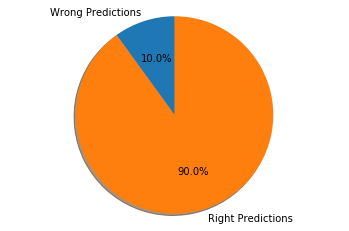

In [0]:
labels = ['Wrong Predictions', 'Right Predictions']
size = [(patrolInstance.wrong_predictions/patrolInstance.total_predictions)*100 , (patrolInstance.right_predictions/patrolInstance.total_predictions)*100]
fig1, ax1 = plt.subplots()
ax1.pie(size, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

## Blocked Users Report after Production Test

In [0]:
allBlockedUsers = patrolInstance.blocked_users.values()

blockedUsersDF = pd.DataFrame([vars(f) for f in allBlockedUsers])

blockedUsersDF.head(10)


,user_id,user_registration_date,user_first_block_date,user_last_block_date,user_country,user_dob
0,ea2d7d6c-21e9-45e5-bf24-73e6c659918d,2019-04-03 11:32:47.953,06-February-2020 17:45:00,06-February-2020 17:45:00,GB,1980-02-04
1,5c910964-b068-4919-8add-05c0a6b019dd,2019-04-07 17:57:02.924,06-February-2020 17:45:01,06-February-2020 17:45:01,FR,1979-07-06
2,a75d66e5-6d9d-4549-9523-270ae5901740,2019-04-04 14:19:53.469,06-February-2020 17:45:01,06-February-2020 17:45:01,RO,1988-01-13
3,9adcb932-d46c-410b-9ba7-476f2fe306d9,2019-04-18 13:14:40.566,06-February-2020 17:45:01,06-February-2020 17:45:01,FR,1970-07-21
4,04e1ba16-494a-4de2-8c9c-95dec30379f5,2019-04-10 11:43:55.137,06-February-2020 17:45:01,06-February-2020 17:45:01,GB,1982-11-07
5,a6224475-d42f-40db-8ead-4e7363e3afd5,2019-04-20 04:44:41.776,06-February-2020 17:45:02,06-February-2020 17:45:02,GB,1999-08-27
6,318586c4-0c9f-4cc5-b967-eb5b8b774a80,2019-04-04 16:42:32.089,06-February-2020 17:45:02,06-February-2020 17:45:02,IT,1964-05-29
7,b9093a91-86f5-4169-9af2-508cc4eec51a,2019-03-27 20:27:26.758,06-February-2020 17:45:02,06-February-2020 17:45:02,GB,1973-05-25
8,52614230-16ea-450d-b21c-1de636a30f9a,2019-04-13 19:48:26.383,06-February-2020 17:45:02,06-February-2020 17:45:02,IT,1995-07-20
9,d98691cd-1e0f-4ec0-a06b-75ec8c4275c9,2019-03-07 06:23:13.553,06-February-2020 17:45:02,06-February-2020 17:45:02,GB,1990-10-02
